In [1]:
# This project is intended to perform a Sentimental Analysis on the Amazon Reviews
# We will be applying the LSTM model on the Amazon reviews to predict the Review Ratings


# We will start by importing all the librabries we need for performing LSTM operation 
# on a Text Review from Amazon and will try find out the negative & positive feedback from those reviews

import numpy as np 
import pandas as pd 
import os
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Flatten
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import string
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

# import pdb; pdb.set_trace() 
import re

C:\Users\akudnaver\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Here we are reading a CSV file using pandas and converting to DataFramce , as the data is already in a row/col format 
# no extra effort required here. 

data = pd.read_excel('../review-details.xlsx')

In [3]:
# in this step we will get rid of all the NAN values across the column for individual rows

data.dropna(axis = 1, how ='any').head()

,report_date,online_store,upc,retailer_product_code,brand,category,sub_category,product_description,review_date,review_rating,...,manufacturer,market,review_type,parent_review,dimension1,dimension2,dimension8,verified_purchase,helpful_review_count,review_hash_id
0,2019-01-02,FRESHAMAZON,8718114216478,B0142CI6FC,Dove Men+Care,Personal Care,Deos,Dove Men+Care Extra Fresh Anti-perspirant Deod...,2019-01-01,5,...,Unilever Global,UK,Organic,Child,Deos,Male Anti-Perspirant Deodorant,Core of the Core,True,0,3f129b02-ea76-0323-bd59-235d97a4f83f
1,2019-01-03,FRESHAMAZON,5000184201199,B014DFNNRY,Marmite,Foods,Savoury,Marmite Spread Yeast Extract 500g,2019-01-02,5,...,Unilever Global,UK,Organic,Child,Savoury,COTC Yeast Extract,Core of the Core,True,0,d7f3b9aa-e8b3-626d-683b-374e201c8315
2,2019-01-03,FRESHAMAZON,5000184201199,B014DFNNRY,Marmite,Foods,Savoury,Marmite Spread Yeast Extract 500g,2019-01-02,4,...,Unilever Global,UK,Organic,Child,Savoury,COTC Yeast Extract,Core of the Core,True,0,e58a523d-0155-a366-f107-7ac6817ac3b7
3,2019-01-03,FRESHAMAZON,8712566479726,B014DFKELC,Knorr,Foods,Savoury,Knorr Beef Stock Pot 8 x 28g,2019-01-02,5,...,Unilever Global,UK,Organic,Parent,Savoury,Beef Stock/Pots/Cubes/Extract/Liquid/Concentrated,Core of the Core,True,0,aaa9bb87-4f99-bb89-65cb-3b400ebb45c0
4,2019-01-03,FRESHAMAZON,8717163536476,B014G37I7E,Cif,Homecare,HHC,Cif Citrus Bathroom Mousse 500ml,2019-01-02,5,...,Unilever Global,UK,Organic,Parent,HHC,Bathroom Mousse,Core of the Core,False,0,48c71b34-d7fe-5e90-51dd-239e153fb0ae


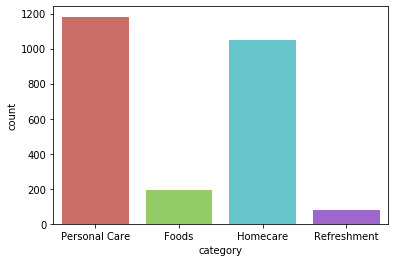

In [4]:
# Lets now get a count of products Amazon is trying to see and get a plot of the count 

sns.countplot(x='category', data=data, palette='hls')

In [5]:
# As the category data is in a lablled format,
# we get a number for each of these different lables by using the Label Encoding method

lb_make = LabelEncoder()
data['category_new'] = lb_make.fit_transform(data['category'])
data[['category_new', 'category']].head()

,category_new,category
0,2,Personal Care
1,0,Foods
2,0,Foods
3,0,Foods
4,1,Homecare


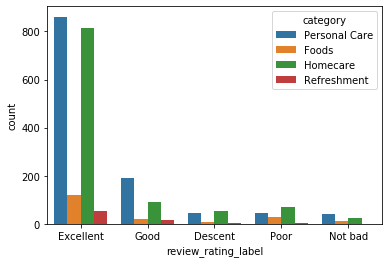

In [6]:
# In this step will get a plot of review_rating across different products ,
# This is a good practice to understand how satisfied the customers are with these products 

mapping = {1: 'Poor', 2: 'Not bad', 3: 'Descent', 4: 'Good', 5: 'Excellent'}

data['review_rating_label'] = data['review_rating'].map(mapping)

sns.countplot(x='review_rating_label', hue='category', data= data)

C:\Users\akudnaver\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\distributions.py:218: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  color=hist_color, **hist_kws)


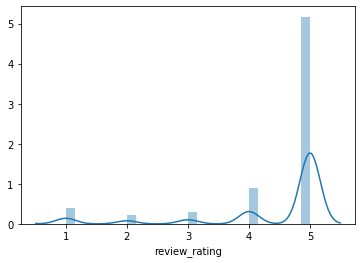

In [7]:
# Lets take a quick peak at the distribution of review_rating
# that will help us decide to get rid of neutral feedbacks
# will try to keep the feedback between Positive and Negatve Reviews

sns.distplot(data['review_rating'])

In [8]:
# Lets display the first 5 rows of our data frame 

data.head(5)

,report_date,online_store,upc,retailer_product_code,brand,category,sub_category,product_description,review_date,review_rating,...,dimension4,dimension5,dimension6,dimension7,dimension8,verified_purchase,helpful_review_count,review_hash_id,category_new,review_rating_label
0,2019-01-02,FRESHAMAZON,8718114216478,B0142CI6FC,Dove Men+Care,Personal Care,Deos,Dove Men+Care Extra Fresh Anti-perspirant Deod...,2019-01-01,5,...,NaN,NaN,NaN,COTC Male Anti-Perspirant Deodorant,Core of the Core,True,0,3f129b02-ea76-0323-bd59-235d97a4f83f,2,Excellent
1,2019-01-03,FRESHAMAZON,5000184201199,B014DFNNRY,Marmite,Foods,Savoury,Marmite Spread Yeast Extract 500g,2019-01-02,5,...,NaN,NaN,NaN,COTC Yeast Extract,Core of the Core,True,0,d7f3b9aa-e8b3-626d-683b-374e201c8315,0,Excellent
2,2019-01-03,FRESHAMAZON,5000184201199,B014DFNNRY,Marmite,Foods,Savoury,Marmite Spread Yeast Extract 500g,2019-01-02,4,...,NaN,NaN,NaN,COTC Yeast Extract,Core of the Core,True,0,e58a523d-0155-a366-f107-7ac6817ac3b7,0,Good
3,2019-01-03,FRESHAMAZON,8712566479726,B014DFKELC,Knorr,Foods,Savoury,Knorr Beef Stock Pot 8 x 28g,2019-01-02,5,...,NaN,NaN,NaN,Stock Pots,Core of the Core,True,0,aaa9bb87-4f99-bb89-65cb-3b400ebb45c0,0,Excellent
4,2019-01-03,FRESHAMAZON,8717163536476,B014G37I7E,Cif,Homecare,HHC,Cif Citrus Bathroom Mousse 500ml,2019-01-02,5,...,NaN,NaN,NaN,NaN,Core of the Core,False,0,48c71b34-d7fe-5e90-51dd-239e153fb0ae,1,Excellent


In [9]:
# Now we have arrive at one of most important step , which is feature extraction,
# I think you should play with less and most significant feature at a time and start adding more feature 
# if you have solid understanding of the industry from where the problem statement is coming from.
# As the whole purpose of this program is Sentimental Analysis on the reviews , am choosing only 2 features as 
# shown below. 

train_data = data[['review_text','review_rating']]

train_data.head()

,review_text,review_rating
0,"As you get older, you know what you like and w...",5
1,Three gigantic marmite jars that will last pro...,5
2,Excellent,4
3,A great flavour top - up for slow cooking.,5
4,Does what is says it does,5


In [10]:
# Data cleaning is vital when it comes to NLP application on the text data

def rem_punctuation(text):
    no_punc = "".join([ x for x in text if x not in string.punctuation])
    return no_punc

In [11]:
# Lets remove all the punctuations from our review_text data

train_data['review_text'] = train_data['review_text'].apply(lambda x: rem_punctuation(x))
train_data['review_text'].head()

C:\Users\akudnaver\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0    As you get older you know what you like and wh...
1    Three gigantic marmite jars that will last pro...
2                                            Excellent
3             A great flavour top  up for slow cooking
4                            Does what is says it does
Name: review_text, dtype: object

In [12]:
# Now we need to tokenize our words in review_text data
# Intantiate Tokenizer

tokenizer = RegexpTokenizer(r'\w+')

In [13]:
# Let's apply the tokenizer on our review text data

train_data['review_text']  = train_data['review_text'].apply(lambda x: tokenizer.tokenize(x.lower()))
train_data['review_text'].head()

C:\Users\akudnaver\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0    [as, you, get, older, you, know, what, you, li...
1    [three, gigantic, marmite, jars, that, will, l...
2                                          [excellent]
3     [a, great, flavour, top, up, for, slow, cooking]
4                     [does, what, is, says, it, does]
Name: review_text, dtype: object

In [14]:
def rem_stopwords(text):
    words = [w for w in text if w in stopwords.words('english')]
    return words

In [15]:
# We need a lemmatizer on our review_text ,Lemmatization  brings context to the words. 
# So it links words with similar meaning to one word. Let see how that helps our model 

lemmatizer = WordNetLemmatizer()

def word_lemmatizer(text):
    lem_text = [lemmatizer.lemmatize(i) for i in text]
    return lem_text

In [16]:
# lets apply the lemmatization function

train_data['review_text']  = train_data['review_text'].apply(lambda x: word_lemmatizer(x))
train_data['review_text'].head()

C:\Users\akudnaver\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0    [a, you, get, older, you, know, what, you, lik...
1    [three, gigantic, marmite, jar, that, will, la...
2                                          [excellent]
3     [a, great, flavour, top, up, for, slow, cooking]
4                        [doe, what, is, say, it, doe]
Name: review_text, dtype: object

In [17]:
# In this step we would like to conclude the review_rating around Postitive=1 and negative=0 values
# We will use these as a classification for our 'review_texts' , more like a feedback from customer !!

train_data.dropna(inplace=True)
train_data[train_data['review_rating'] != 3]
train_data['Positivity'] = np.where(train_data['review_rating'] > 3, 1, 0)
cols = ['review_rating']
train_data.drop(cols, axis=1, inplace=True)
train_data.head()

C:\Users\akudnaver\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\akudnaver\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\akudnaver\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing

,review_text,Positivity
0,"[a, you, get, older, you, know, what, you, lik...",1
1,"[three, gigantic, marmite, jar, that, will, la...",1
2,[excellent],1
3,"[a, great, flavour, top, up, for, slow, cooking]",1
4,"[doe, what, is, say, it, doe]",1


In [18]:
# Just getting a count of Positive and Negative counts
# train_data.groupby('Positivity').size()

# sns.countplot(x='Positivity', data = train_data, palette = 'hls')

In [19]:
# By now we are finished with pre-processing our text_review column 
# So lets go ahead and extract the X = features and Y target label

X = train_data['review_text']
Y = train_data['Positivity']

train_data['review_text']=[" ".join(review) for review in train_data['review_text'].values]
train_data['review_text'].head()

C:\Users\akudnaver\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


0    a you get older you know what you like and wha...
1    three gigantic marmite jar that will last prob...
2                                            excellent
3              a great flavour top up for slow cooking
4                               doe what is say it doe
Name: review_text, dtype: object

In [20]:
# Here we are splitting the X & Y data with a test size = 20 % 

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

In [21]:
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(2000,) (2000,)
(501,) (501,)


In [22]:
# This step is to check the ratio of positive to negatives values in our Test and Train Dataset

print("Train set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(X_train),
                                                                             (len(X_train[Y_train == 0]) / (len(X_train)*1.))*100,
                                                                        (len(X_train[Y_train == 1]) / (len(X_train)*1.))*100))
print("Test set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(X_test),
                                                                             (len(X_test[Y_test == 0]) / (len(X_test)*1.))*100,
                                                                            (len(X_test[Y_test == 1]) / (len(X_test)*1.))*100))

Train set has total 2000 entries with 13.35% negative, 86.65% positive
Test set has total 501 entries with 13.37% negative, 86.63% positive


In [23]:
# Now it is equally important to check how balanced our Classfication data is w.r.t Positive and Negative rating 

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

def accuracy_summary(pipeline, X_train, y_train, X_test, y_test):
    sentiment_fit = pipeline.fit(X_train, y_train)
    y_pred = sentiment_fit.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("accuracy score: {0:.2f}%".format(accuracy*100))
    return accuracy

In [24]:
# As i was mentioning earlier that choosing the correct number of features plays a vital role in creating a model for 
# an accurate predictions ,it is a good practice to check the number of features having an impact on 
# our accuracy score, so we will take advantage of Random Forest to be able to achieve that, so lets begin !!

cv = CountVectorizer()
rf = RandomForestClassifier(class_weight="balanced")
n_features = np.arange(10000,25001,5000)

def nfeature_accuracy_checker(vectorizer=cv, n_features=n_features, stop_words=None, ngram_range=(1, 1), classifier=rf):
    result = []
    print(classifier)
    print("\n")
    for n in n_features:
        vectorizer.set_params(stop_words=stop_words, max_features=n, ngram_range=ngram_range)
        checker_pipeline = Pipeline([('vectorizer', vectorizer),('classifier', classifier)])
        print("Test result for {} features".format(n))
        nfeature_accuracy = accuracy_summary(checker_pipeline, X_train, Y_train, X_test, Y_test)
        result.append((n,nfeature_accuracy))
    return result
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
print("Result for trigram with stop words (Tfidf)\n")
feature_result_tgt = nfeature_accuracy_checker(vectorizer=tfidf,ngram_range=(1, 4))

Result for trigram with stop words (Tfidf)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)


Test result for 10000 features
accuracy score: 91.02%
Test result for 15000 features
accuracy score: 91.82%
Test result for 20000 features
accuracy score: 91.82%
Test result for 25000 features
accuracy score: 91.22%


In [25]:
# In this step we are checking the classification report across negative and positive rating 

from sklearn.metrics import classification_report
cv = CountVectorizer(max_features=30000,ngram_range=(1, 3))
pipeline = Pipeline([('vectorizer', cv),('classifier', rf)])
sentiment_fit = pipeline.fit(X_train, Y_train)
y_pred = sentiment_fit.predict(X_test)
print(classification_report(Y_test, y_pred, target_names=['negative','positive']))
# print(cv.get_feature_names())

             precision    recall  f1-score   support

   negative       0.94      0.46      0.62        67
   positive       0.92      1.00      0.96       434

avg / total       0.93      0.92      0.91       501



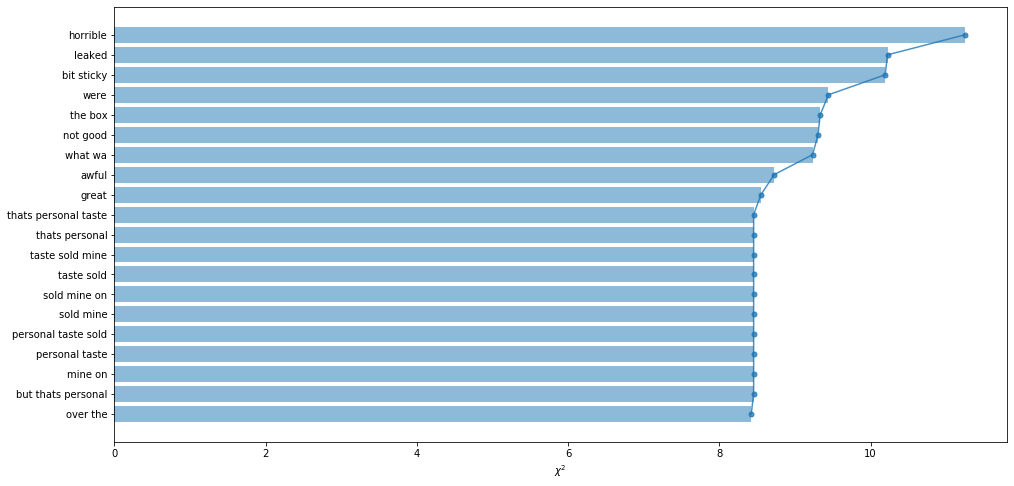

In [26]:
# Well a chi2 score is always benefinicial to learn the words having less dependencies for hypothesis
# and thus can be ignored during the feature selection process, the primary reason for using chi2 sqaure method.

from sklearn.feature_selection import chi2
tfidf = TfidfVectorizer(max_features=30000,ngram_range=(1, 3))
X_tfidf = tfidf.fit_transform(train_data['review_text'])
y = train_data['Positivity']
chi2score = chi2(X_tfidf, y)[0]
plt.figure(figsize=(16,8))
scores = list(zip(tfidf.get_feature_names(), chi2score))
chi2 = sorted(scores, key=lambda x:x[1])
topchi2 = list(zip(*chi2[-20:]))
x = range(len(topchi2[1]))
labels = topchi2[0]
plt.barh(x,topchi2[1], align='center', alpha=0.5)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels)
plt.xlabel('$\chi^2$')
plt.show();

In [27]:
# We need a final pre-paration before we input it to our LSTM Model, which is the next step
# we start with setting to text to sequence and pad the sequence for an equal lenght of input data to be fed
# to our LSTM model. 

MAX_NB_WORDS = 50000
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(data['review_text'].values)

X1 = tokenizer.texts_to_sequences(train_data['review_text'].values)
X1 = pad_sequences(X1)
Y1 = pd.get_dummies(train_data['Positivity']).values
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1,Y1, random_state = 42)
print(X1_train.shape,Y1_train.shape)
print(X1_test.shape,Y1_test.shape)
# print(Y1)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
print(X1.shape[1])
X1

(1875, 278) (1875, 2)
(626, 278) (626, 2)
Found 3889 unique tokens.
278


array([[  0,   0,   0, ...,  12,  51, 951],
       [  0,   0,   0, ..., 121,  24,   6],
       [  0,   0,   0, ...,   0,   0, 180],
       ...,
       [  0,   0,   0, ...,   9,   2,  79],
       [  0,   0,   0, ...,  40,  37, 655],
       [  0,   0,   0, ...,  20, 399, 121]])

In [28]:
# Finally we have arrived at designing our LSTM model

# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 278
# This is fixed.
EMBEDDING_DIM = 150
lstm_out = 200
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X1.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 278, 150)          7500000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 278, 150)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 200)               280800    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 402       
Total params: 7,781,202
Trainable params: 7,781,202
Non-trainable params: 0
_________________________________________________________________


In [29]:
# At this step we set few parameters based our own experience which will come to you overtime.
# So basically we setting a batch size for our input data and epoch= for number of iterations our model
# has to go through !!!

batch_size = 32
history = model.fit(X1_train, Y1_train, nb_epoch = 5, batch_size=batch_size, verbose = 2)

C:\Users\akudnaver\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\models.py:981: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/5
 - 73s - loss: 0.3866 - acc: 0.8587
Epoch 2/5
 - 80s - loss: 0.2533 - acc: 0.9029
Epoch 3/5
 - 67s - loss: 0.1664 - acc: 0.9499
Epoch 4/5
 - 72s - loss: 0.1037 - acc: 0.9664
Epoch 5/5
 - 77s - loss: 0.0765 - acc: 0.9787


In [30]:
accuracy = model.evaluate(X1_test, Y1_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accuracy[0],accuracy[1]))

626/626 [==============================] - 6s 9ms/step
Test set
  Loss: 0.299
  Accuracy: 0.912


In [31]:
# from keras.callbacks import History 
# history = History()
# history.model
print(history.history.keys())

dict_keys(['loss', 'acc'])


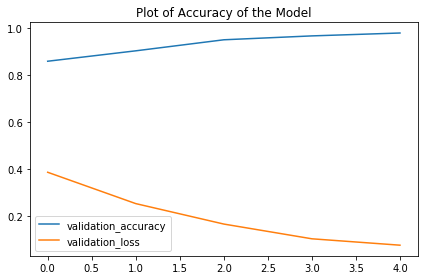

In [32]:
# Finally, we can see that the validation loss and validation accuracy both are in sync with the training loss and 
# accuracy .Even though the validation loss and accuracy line are not linear, but it shows that your model is not 
# overfitting: the validation loss is decreasing and not increasing, and there is not much gap between training 
# and validation accuracy.

plt.title('Plot of Accuracy of the Model')
plt.plot(history.history['acc'], label='validation_accuracy')
plt.plot(history.history['loss'], label='validation_loss')
plt.legend()
plt.tight_layout()
plt.show()

In [33]:
# Lets find the percentage of Positive & Negative reviews with our existing LSTM model . 

pos_cnt, neg_cnt, pos_correct, neg_correct = 0, 0, 0, 0
for x in range(len(X1_test)):
    
    result = model.predict(X1_test[x].reshape(1,X1_test.shape[1]),batch_size=1,verbose = 2)
   
    if np.argmax(result) == np.argmax(Y1_test[x]):
        if np.argmax(Y1_test[x]) == 0:
            neg_correct += 1
        else:
            pos_correct += 1
       
    if np.argmax(Y1_test[x]) == 0:
        neg_cnt += 1
    else:
        pos_cnt += 1

predicted_classes = model.predict(X1_test)
# predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
# predicted_classes.shape, X1_test.shape
print("pos_acc", pos_correct/pos_cnt*100, "%")
print("neg_acc", neg_correct/neg_cnt*100, "%")
# pos_acc 90.67439409905164 %
# neg_acc 63.2890365448505 %

pos_acc 99.25512104283054 %
neg_acc 42.69662921348314 %


In [34]:
# predicted_classes = model.predict(X1_test)
# predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
# predicted_classes.shape, X1_test.shape

In [35]:
# Okay so far we have finished creating an LSTM model for our review_text analysis.
# Now lets see how efficient our model is to make prediction on the raw data, which may not
# be in the dataset . Excited me too , finger crossed :)

# Test case 1: Checking Positive reviews

new_review = ['by far the best product i have come across']
seq = tokenizer.texts_to_sequences(new_review)
print(seq)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
# labels = ['Positive', 'Negative']
labels = {0: 'Negative', 1: 'Positive'}
# # labels = ['Credit reporting, credit repair services, or other personal consumer reports', 'Debt collection', 'Mortgage', 'Credit card or prepaid card', 'Student loan', 'Bank account or service', 'Checking or savings account', 'Consumer Loan', 'Payday loan, title loan, or personal loan', 'Vehicle loan or lease', 'Money transfer, virtual currency, or money service', 'Money transfers', 'Prepaid card']
print(labels[np.argmax(pred)])
print(pred)

[[159, 368, 2, 148, 18, 3, 16, 268, 991]]
Positive
[[0.13992986 0.8600701 ]]


In [36]:
# Okay so far we have finished creating an LSTM model for our review_text analysis.
# Now lets see how efficient our model is to make prediction on the raw text, which may not
# be in the dataset . Excited me too , finger crossed :)

# Test case 1: Checking negative reviews

new_review = ['by far the worst product i have come across']
seq = tokenizer.texts_to_sequences(new_review)
print(seq)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
# labels = ['Positive', 'Negative']
labels = {0: 'Negative', 1: 'Positive'}
# # labels = ['Credit reporting, credit repair services, or other personal consumer reports', 'Debt collection', 'Mortgage', 'Credit card or prepaid card', 'Student loan', 'Bank account or service', 'Checking or savings account', 'Consumer Loan', 'Payday loan, title loan, or personal loan', 'Vehicle loan or lease', 'Money transfer, virtual currency, or money service', 'Money transfers', 'Prepaid card']
print(labels[np.argmax(pred)])
print(pred)

[[159, 368, 2, 1869, 18, 3, 16, 268, 991]]
Negative
[[0.7946179  0.20538211]]
